In [4]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## 数据处理

In [6]:
trans = transforms.Compose([transforms.ToTensor()])

dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=trans, download=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [8]:
x, y = next(iter(dataloader))
x.shape

torch.Size([256, 1, 28, 28])

## 模型构建

**VAE模型定义**

In [12]:
class VAE(nn.Module):
    """ 变分自编码器 """
    def __init__(self, latent_size=32):
        super().__init__()
        # Encoder 编码器
        self.encoder = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2), 
                                     nn.ReLU(), 
                                     nn.Conv2d(16, 32, kernel_size=5, padding=2), 
                                     nn.ReLU(),
                                     nn.Flatten())
        
        # 计算 Latent Space的均值和对数方差
        self.fc_mu = nn.Linear(32*28*28, latent_size)
        self.fc_logvar = nn.Linear(32*28*28, latent_size)
        
        # Decoder 解码器
        self.decoder = nn.Sequential(nn.Linear(latent_size, 32*28*28), 
                                     nn.ReLU(), 
                                     nn.Unflatten(-1, (32, 28, 28)),
                                     nn.ConvTranspose2d(32, 16, kernel_size=5, padding=2),
                                     nn.ReLU(), 
                                     nn.ConvTranspose2d(16, 1, kernel_size=5, padding=2),
                                     nn.Sigmoid())   # 将输出压缩在 (0, 1) 的范围内
        
    def reparameterize(self, mu, logvar):
        """ 重参数化方法 """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """ 前向传播方法 """
        # Encoding 编码过程
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)

        # Reparameterize 重参数化过程
        z = self.reparameterize(mu, logvar)

        # Decoding 解码过程
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [16]:
model = VAE()
x_recon, mu, logvar = model(torch.rand(16, 1, 28, 28))
x_recon.shape, mu.shape, logvar.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16, 32]), torch.Size([16, 32]))

**损失函数**

In [19]:
def vae_loss(x_recon, x, mu, logvar):
    """ 自定义损失函数, 用于描述重建损失 Loss = 重构损失 + KL散度 """
    # 重构损失
    BCE = F.binary_cross_entropy(x_recon, x.view(-1, 1, 28, 28), reduction="sum")
    
    # KL散度
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

**模型构建**

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [24]:
model = VAE().to(device)
loss_func = vae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 模型训练与评估

**模型训练**

In [29]:
def train_model(model, dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    model.train()
    total_loss = 0
    for x, _ in dataloader:
        x_recon, mu, logvar = model(x.to(device).view(-1, 1, 28, 28))
        loss = loss_func(x_recon, x.to(device), mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [32]:
n_epoch = 200

train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {round(loss, 4)}")

Epoch 1 loss: 74755.1989
Epoch 2 loss: 53448.2273
Epoch 3 loss: 49623.3701
Epoch 4 loss: 43104.7168
Epoch 5 loss: 38033.9216
Epoch 6 loss: 34739.3789
Epoch 7 loss: 32384.0721
Epoch 8 loss: 30825.1609
Epoch 9 loss: 29680.5654
Epoch 10 loss: 28979.6303
Epoch 11 loss: 28413.2033
Epoch 12 loss: 28004.5698
Epoch 13 loss: 27668.3662
Epoch 14 loss: 27498.0437
Epoch 15 loss: 27299.318
Epoch 16 loss: 27117.6237
Epoch 17 loss: 26874.2366
Epoch 18 loss: 26682.2209
Epoch 19 loss: 26553.2497
Epoch 20 loss: 26505.7203
Epoch 21 loss: 26381.1649
Epoch 22 loss: 26360.2189
Epoch 23 loss: 26230.9933
Epoch 24 loss: 26201.6479
Epoch 25 loss: 26162.2655
Epoch 26 loss: 26040.1437
Epoch 27 loss: 25987.8255
Epoch 28 loss: 25917.0328
Epoch 29 loss: 25860.4502
Epoch 30 loss: 25796.551
Epoch 31 loss: 25750.8742
Epoch 32 loss: 25736.7298
Epoch 33 loss: 25719.6835
Epoch 34 loss: 25732.4635
Epoch 35 loss: 25613.7784
Epoch 36 loss: 25582.1605
Epoch 37 loss: 25582.3495
Epoch 38 loss: 25488.7123
Epoch 39 loss: 25440.00

**损失可视化**

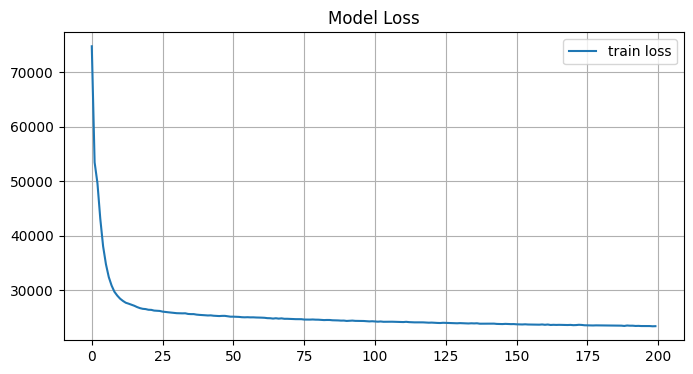

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(train_loss, label='train loss')
plt.title('Model Loss')
plt.grid()
plt.legend()
plt.show()